In [7]:
from my_lda_func_V3 import *
import nltk
from nltk.corpus import reuters
import lda_class_carol
from plsa import Corpus, Pipeline, Visualize
from plsa.algorithms import PLSA
from plsa.pipeline import DEFAULT_PIPELINE

In [8]:
nltk.download('reuters')

[nltk_data] Downloading package reuters to /home/jovyan/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [9]:
np.random.seed(1)
ntotal=1000
num_topics=5
documents = reuters.fileids()
documents=np.random.choice(documents,ntotal)
docs=[reuters.raw(d) for d in documents]
labels1=[('earn' in reuters.categories(d)) for d in documents]
tf_df, id2word = tf(docs)


In [27]:
lil = []
for row in tf_df.values:
    lil_sub = []
    for idx, item in enumerate(row):
        if item:
            lil_sub.append((idx, item))
    lil.append(lil_sub)
gamma_chunk=my_lda_func(corpus=lil, num_topics=num_topics, id2word=id2word, topics_only=False,chunksize=100)[1]
res_lda1=np.concatenate([gamma_chunk[i] for i in np.arange(0,ntotal,100)])
file = open("results/res_lda1_"+str(num_topics), "wb")
np.save(file, res_lda1)
file.close

<function BufferedWriter.close>

In [30]:
# already saved
# b=lda_class_carol.LDA2(docs)
# res_lda2=b.lda(num_topics=num_topics,conv_threshold=1e-2,max_iter=100,npass=1)
# res_lda2=np.array(b.gamma)
# file = open("results/res_lda2_"+str(num_topics), "wb")
# np.save(file, res_lda2)
# file.close

In [36]:
# already saved
# pipeline = Pipeline(*DEFAULT_PIPELINE)
# corpus_plsa=Corpus(docs,pipeline)
# plsa=PLSA(corpus_plsa, num_topics, True)
# result = plsa.fit()
# res_plsa=result.topic_given_doc
# file = open("results/res_plsa_"+str(num_topics), "wb")
# np.save(file, res_plsa)
# file.close

<function BufferedWriter.close>

In [38]:
# already saved
# %%timeit -n 1 -r 1
# bigram
# see https://scikit-learn.org/stable/modules/feature_extraction.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# vectorizer.fit_transform(docs)
# analyze = vectorizer.build_analyzer()
# bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1)
# analyze = bigram_vectorizer.build_analyzer()
# res_bigram=bigram_vectorizer.fit_transform(docs).toarray()
# file = open("results/res_bigram_"+str(num_topics), "wb")
# np.save(file, res_bigram)
# file.close

<function BufferedWriter.close>

In [39]:
#SVM

In [10]:
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [14]:
file = open("results/res_plsa_"+str(num_topics), "rb")
res_plsa=np.load(file)
file.close
file = open("results/res_lda1_"+str(num_topics), "rb")
res_lda1=np.load(file)
file.close
file = open("results/res_lda2_"+str(num_topics), "rb")
res_lda2=np.load(file)
file.close
file = open("results/res_bigram_"+str(num_topics), "rb")
res_bigram=np.load(file)
file.close

<function BufferedReader.close>

In [15]:
methods='plsi,lda1,lda2,bigram'.split(',')
prop=[0.01,0.05,0.1,0.2,0.3,0.5]
acclist=[]
nmc=20
for l in range(nmc):
    acc=np.zeros((len(prop),len(methods)))
    for j,p in enumerate(prop):
        print(l,j)
        for i,x in enumerate([res_plsa,res_lda1,res_lda2,res_bigram]):
            X_train, X_test, y_train, y_test = train_test_split(x, np.array(labels1), test_size=1-p, random_state=l)
            clf = svm.SVC(kernel='linear')
            clf.fit(X_train, y_train)
            clf_predictions = clf.predict(X_test)
            acc[j,i]=clf.score(X_test, y_test)
            #print("Accuracy of {}: {}%".format(p,acc[j,i] * 100))
    file = open("results/accuracy_1000/acc"+str(l)+'_'+str(num_topics)+'topics', "wb")
    #np.save(file, acclist)
    np.save(file, acc)
    file.close
    acclist.append(acc)
    print(acc)
file = open("results/accuracy_1000acclist"+str(l)+'_'+str(num_topics)+'topics', "wb")
np.save(file, acclist)
file.close

0 0


KeyboardInterrupt: 

In [16]:
# from functools import reduce
# acclist=[np.load('acc'+str(l)) for l in range(50) if not l==25]
# acclist1=[acc for acc in acclist if not acc.shape==(0,)]
# acc_avg=np.array(reduce(lambda x,y:x+y, acclist1))/len(acclist1)
# file = open("acc_avg", "wb")
# np.save(file, acc_avg)
# file.close

In [17]:
nmc=19
acclist=[]
for i in range(nmc):
    file = open("results/accuracy_1000/acc"+str(i)+'_'+'5topics', "rb")
    acc_i=np.load(file)
    file.close
    acclist.append(acc_i)

In [18]:
acc_all=np.array(acclist)
acc_avg=np.mean(acc_all,axis=0)
acc_sd=np.std(acc_all,axis=0)

In [29]:
import pandas as pd
df_avg=pd.DataFrame(acc_avg,columns=methods)
df_avg['proportion of training data']=prop
df_sd=pd.DataFrame(acc_sd,columns=methods)
df_sd['proportion of training data']=prop
avg=df_avg.melt(id_vars='proportion of training data')
avg.columns=['proportion of training data','model','avg']
sd=df_sd.melt(id_vars='proportion of training data')
sd.columns=['prop','variable','sd']
df=pd.concat([avg,sd],axis=1)

In [30]:
import matplotlib.pyplot as plt

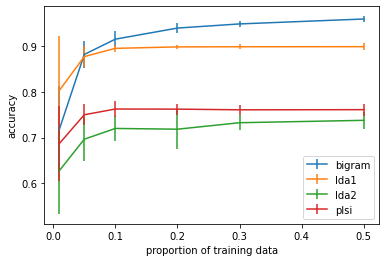

In [33]:
# Subplots as having two types of quality
fig, ax = plt.subplots()

for key, group in df.groupby('model'):
    group.plot('proportion of training data', 'avg', yerr='sd',
        label=key, ax=ax)
plt.ylabel('accuracy')
plt.savefig('figures/accuracy.png', dpi = 1000)
pass

In [34]:
df

,proportion of training data,model,avg,prop,variable,sd
0,0.01,plsi,0.687081,0.01,plsi,0.082790
1,0.05,plsi,0.750083,0.05,plsi,0.023319
2,0.10,plsi,0.762690,0.10,plsi,0.017950
3,0.20,plsi,0.762434,0.20,plsi,0.011792
4,0.30,plsi,0.760977,0.30,plsi,0.010323
5,0.50,plsi,0.761263,0.50,plsi,0.013030
6,0.01,lda1,0.803668,0.01,lda1,0.118320
7,0.05,lda1,0.877729,0.05,lda1,0.023612
8,0.10,lda1,0.895789,0.10,lda1,0.008451
9,0.20,lda1,0.899013,0.20,lda1,0.004943
